# Correctly Applying SVMs In Classification

SVMs are powerful tools in classification that rely on the definition of support vectors to split elements along a decision boundary. In this tutorial, we'll be looking at two kernel methods, the linear and RBF kernels.

## How To Decide On What Kernel To Use

There are a range of kernel methods out there for differing classification problems. To  know when to apply a certain kernel, we need to understand how it attempts to split up the data. Take for instance the linear kernel, which essentially forms a boundary between data using a single gradating line. 

![](margins.png)

This is very similar to the idea of a linear function, and can even be colloquially described e.g. as X increases, so does the Y of the Z. So then if this kernel is so simple, where might it be used? Consider the Meyer-Overton correlation which shows that as concentration of a anaesthetic increases, so does the potency of its usage on a patient.

![](meyer.png)

https://link.springer.com/article/10.1007/BF01834479

This is a great example of where a linear kernel might be useful; you'd give the classifier the various concentrations, it would learn how it affects potency, and then it would be able to generalise how any concentration would affect a person.

But then, what about data that isn't linearly separable? Well for cases like this, we can refer to other well-known kernel methods, like the RBF kernel (which has been found to provide strong results under general terms).

Unfortunately, the RBF kernel may require an explanation that goes a little beyond colloquial discussion, however we'll let this become evident during (and after our analysis).

## A Business Concern: Prescribing The Correct Dosage

A clinic has recently begun trialling a drug that is capable of curing chronic arthritis, through the compound of two separate chemicals. The results have been promising, however it has been found that certain dosage combinations of each of the chemicals can have adverse effects, and actually inflames the joints of the prescribant.

The clinic wants to be able to decide in a general sense how much of each chemical should be administered. As the drug may be given to different age ranges, there can't be any single dosage that fits all, so they need as much statistical advice as they can get on the matter.

### Load Up The Dataset

The laboratory has sent through all clinical trials that they undertook with the forementioned drug. As you can see, the chemical doses of the two components are fairly different in magnitude.

In [188]:
import pandas as pd

data = pd.read_csv("results.csv")
data

,Chemical A Dosage (ml),Chemical B Dosage (ml),Test Success
0,438.0,10.44,0
1,427.8,9.88,0
2,446.2,9.47,0
3,453.0,10.58,0
4,483.4,11.36,0
...,...,...,...
165,406.2,14.35,1
166,401.2,13.93,1
167,403.6,14.18,1
168,410.2,14.13,1


### Recalling SVMs

The great thing about using an SVM for this scenario is that it is able to classify data that may be non-linearly separable, all the while determining the correct dosages for a variety of chemical configurations. The objective here would be to train an SVM classifier, and then return the classifier back to the clinic, such that they would be able to use it to inform their decision-making on prescribing dosages.


### Import The Required Libraries

Here, we import all the libraries we will be needing. Refer to https://scikit-learn.org/stable/modules/svm.html for more details on working with SVM in Python.

In [189]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


### Are There Any Patterns We Can See In The Data?

We can't classify anything unless a clear distinction of classes can be seen in the data. In the case that we are dealing with, its important to look at what patterns exist in the data before we consider utilising SVM to assist us.

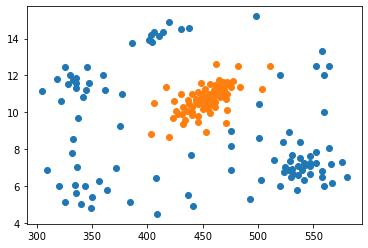

In [190]:
import matplotlib.pyplot as plt

plt.scatter(list(data[data.columns[0]][(data['Test Success'] == 1)]),list(data[data.columns[1]][(data['Test Success'] == 1)]))
plt.scatter(list(data[data.columns[0]][(data['Test Success'] == 0)]),list(data[data.columns[1]][(data['Test Success'] == 0)]))


### Scale The Data

SVM classification will not be mechanically possible unless we scale the data. As a rule of thumb, we can do this with a ___new value of column = (some original value of column - minimum value of column) / (maximum value of column - minimum value of column)___ calculation. This is just a starting method of scalation, however depending on the magnitudes of the columns, you can modify this calculation to suit your liking.

In [191]:

# Features given to the classifier need to be scaled between -1 and 1

def scale_data(data, column_id):
    return ((np.array(data[data.columns[column_id]])-data[data.columns[column_id]].min()) / 
            (data[data.columns[column_id]].max()-data[data.columns[column_id]].min()))
adjusted_svm_data = (np.column_stack(( scale_data(data, 0), scale_data(data, 1))), np.array(data[data.columns[2]]))

#adjusted_svm_data

### Run The Classifier

Here, we run the classifier in order to determine how the classes are separated using SVM. Recall the linear and RBF kernel methods. We can pitch them against each other here and measure the results:

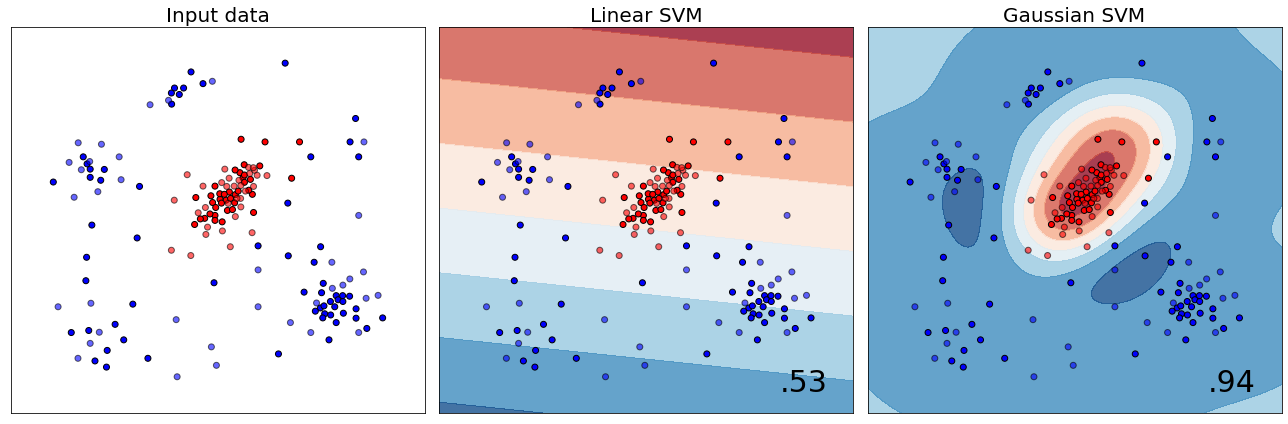

([0.5294117647058824, 0.9411764705882353], <Figure size 1296x432 with 3 Axes>)

In [196]:
# Produced in modification by Abdul Obeid, from code source of Gaël Varoquaux Andreas Müller, and later modification by Jaques Grobler
# License: BSD 3 clause
def run_classifiers(c_of_linear=0.025, c_of_rbf=1, gamma_of_rbf=2, show=True):
    h = .02  # step size in the mesh

    classifiers = [ SVC(kernel="linear", C=c_of_linear), SVC(gamma=gamma_of_rbf, C=c_of_rbf) ]

    X, y = make_classification( n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1 )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)
    names = ['Linear SVM', "Gaussian SVM"]
    datasets = [adjusted_svm_data]

    figure = plt.figure(figsize=(18, 6))
    i = 1
    # iterate over datasets
    scores_tally = []
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=.4, random_state=42)

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data", size=20)
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
                   edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k')
            # Plot the testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name, size=20)
            ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=30, horizontalalignment='right')
            i += 1
            scores_tally.append(score)
    if (show):
        plt.tight_layout()
        plt.show()
    
    return scores_tally, figure
run_classifiers()

## The Hyper-Parameter C

To improve classification, kernel functions aim to produce hyperplanes that correctly separate as many elements as possible, while simultaneously maximising decision boundaries for improved generalisation. The hyper-parameter C can be used to optimise an SVC, as a cost function associated with mis-classification of elements in feature spaces of the 'training' set.

Specifying a meaningful range for evaluation of hyper-parameter C (or any model parameter for that matter) is not easily achieved, as global optimisation in SVCs is limited to capacity for function evaluations. For Gaussian kernels (like the RBF kernel), we can approximate ranges through heuristics, but in this example, we'll keep things simple and stick to an iterative test:

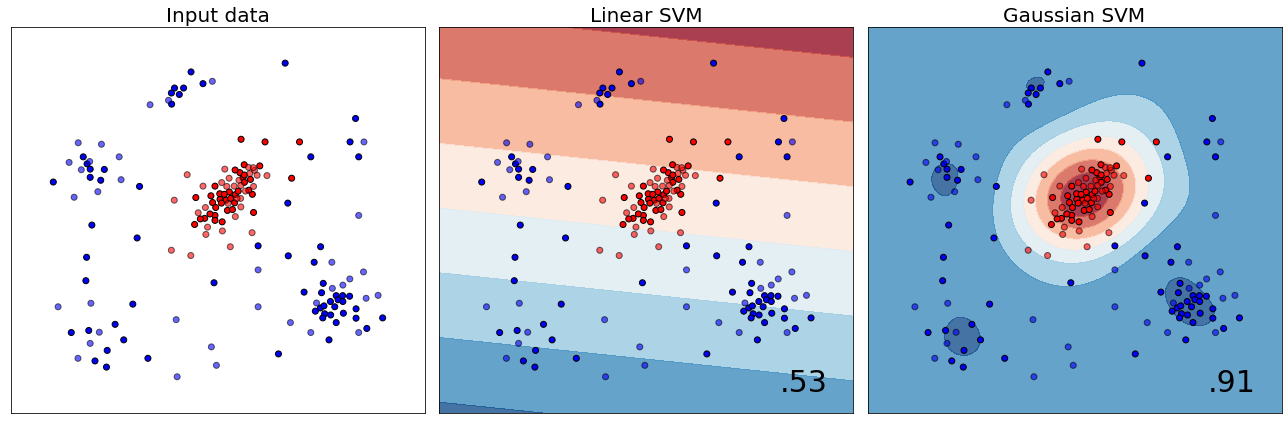

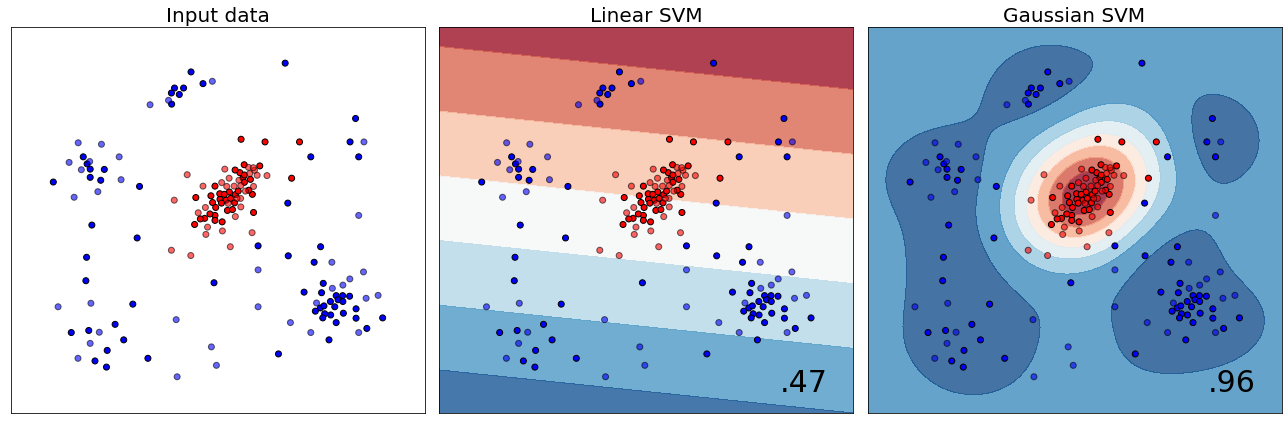

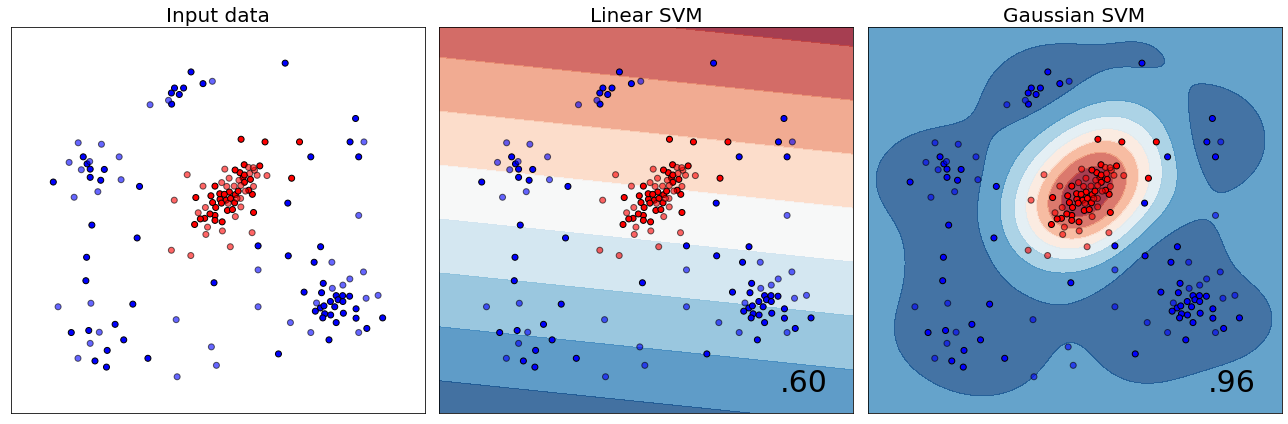

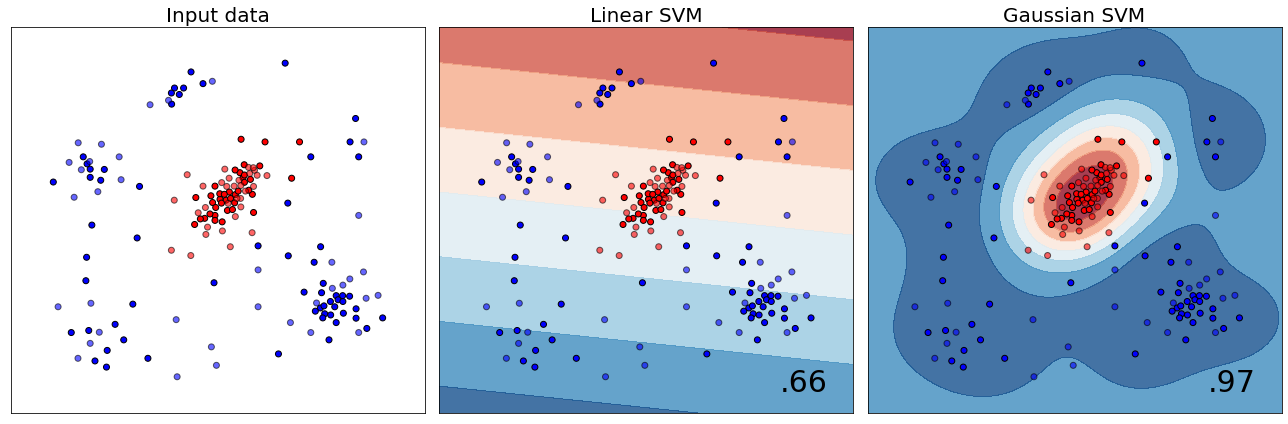

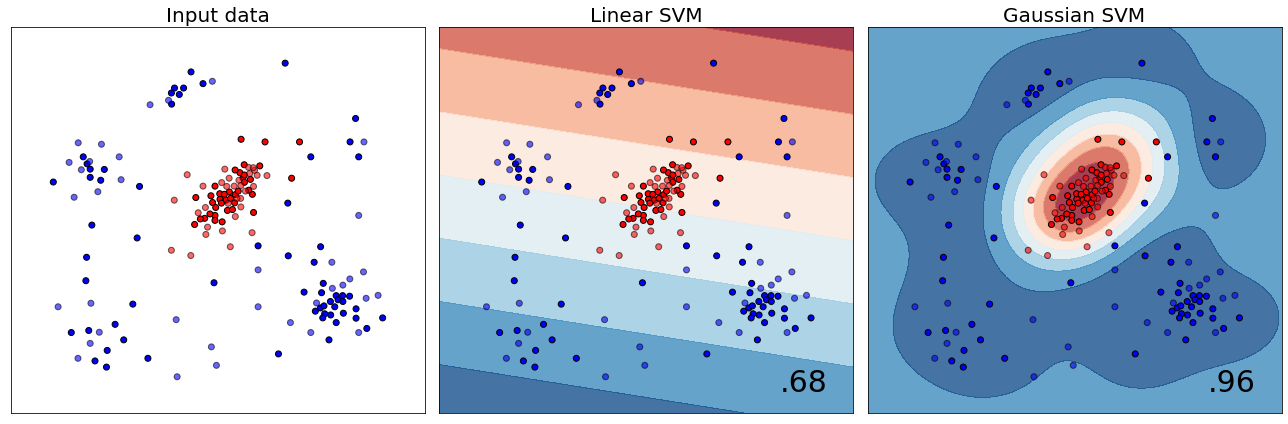

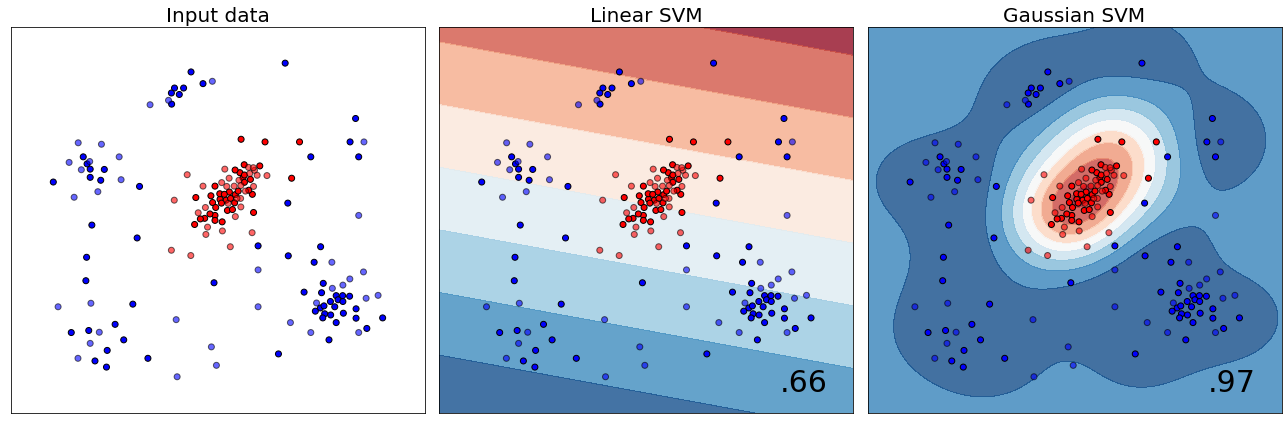

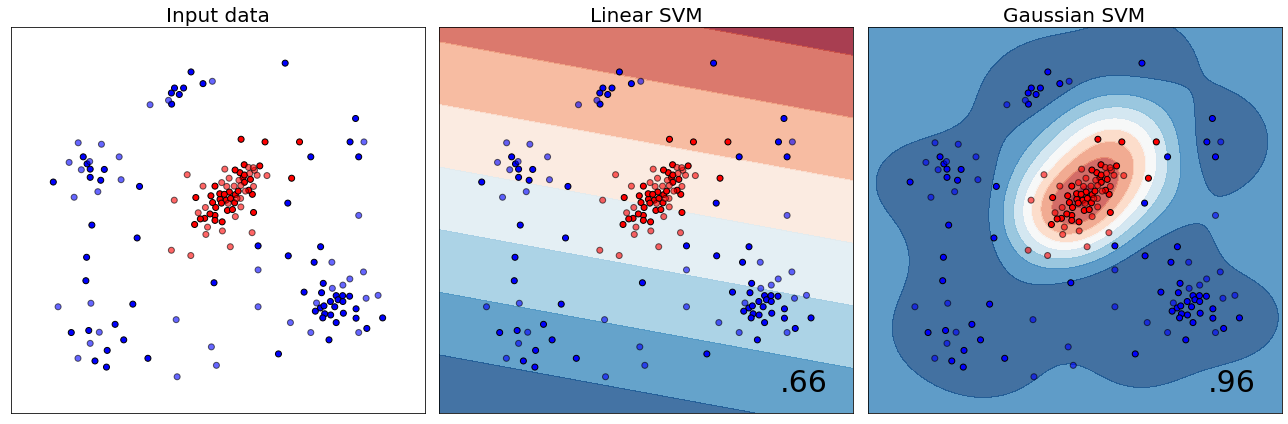

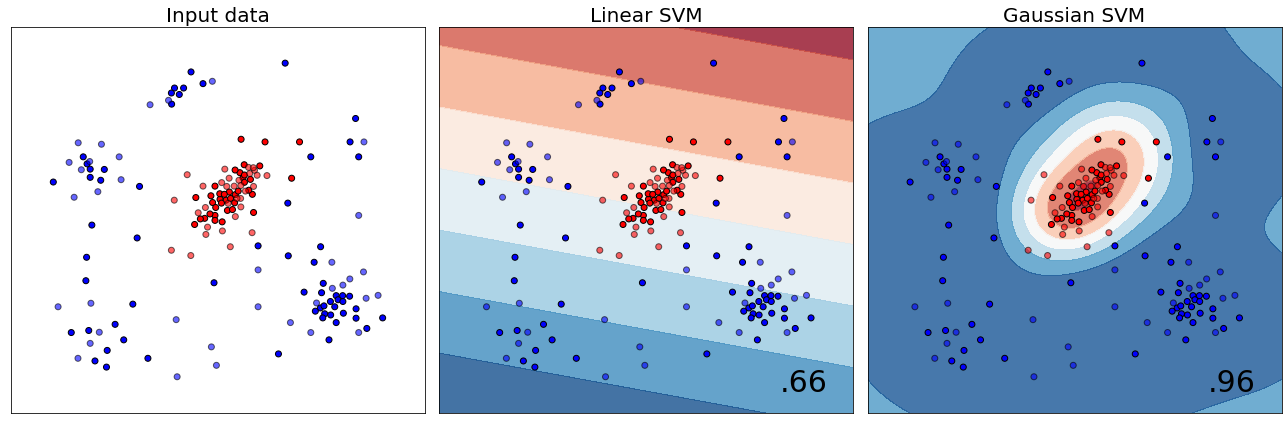

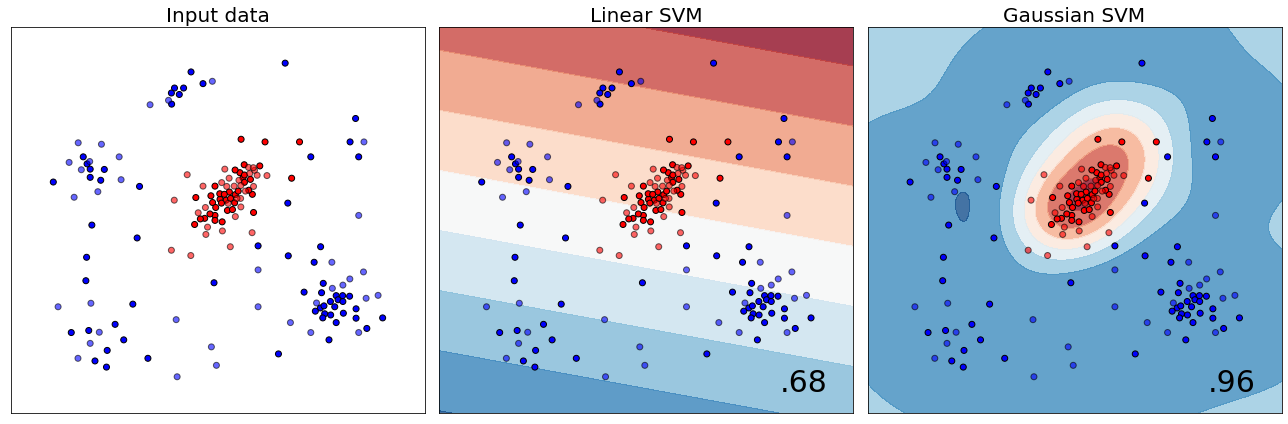

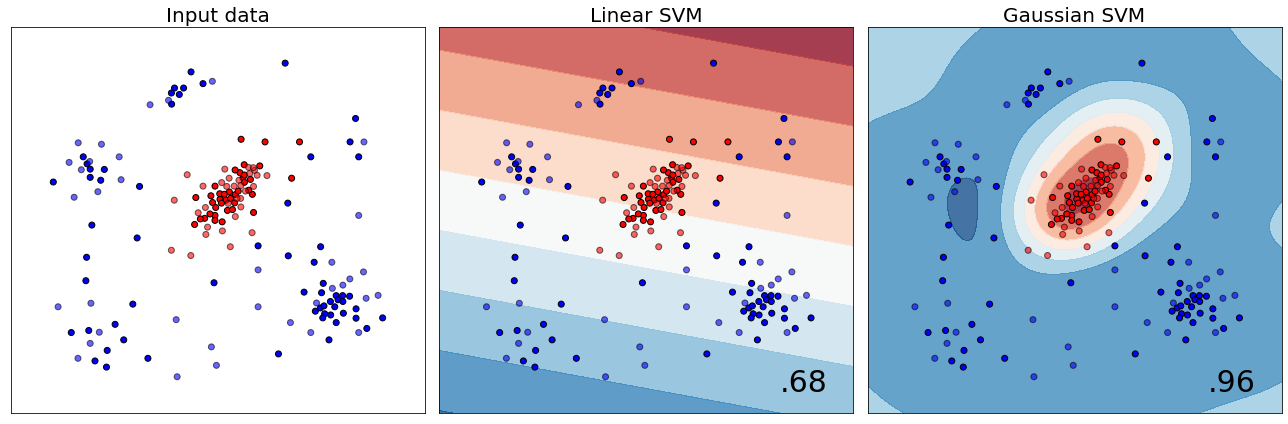

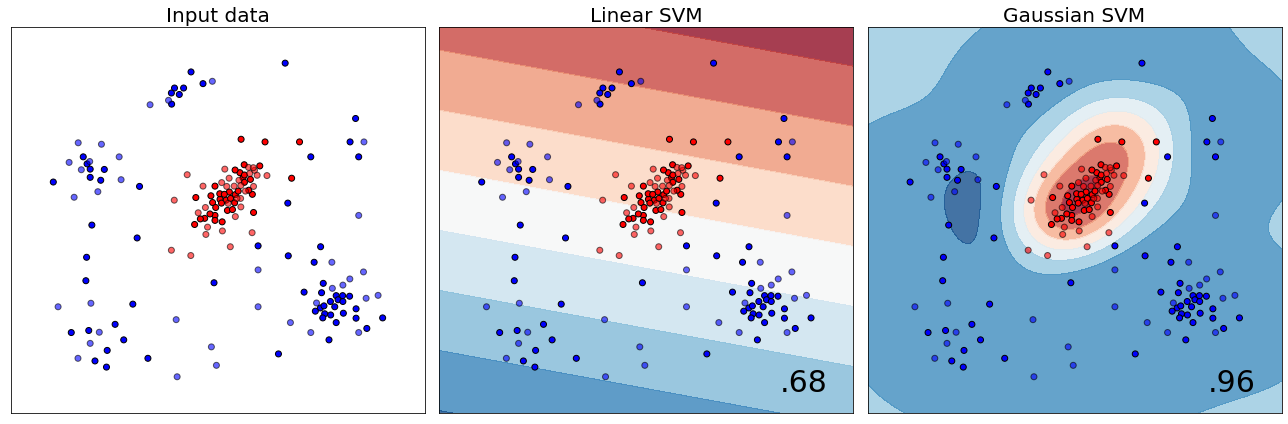

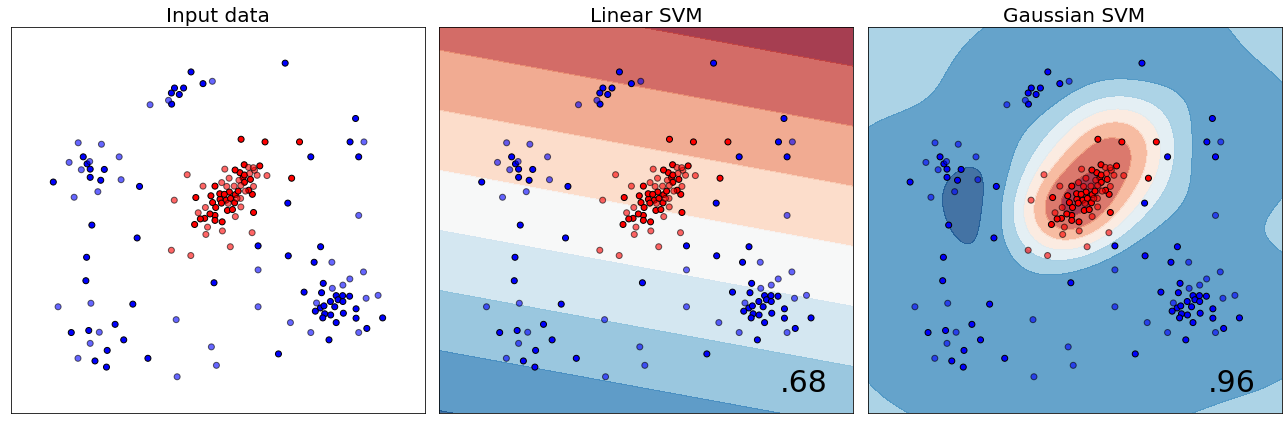

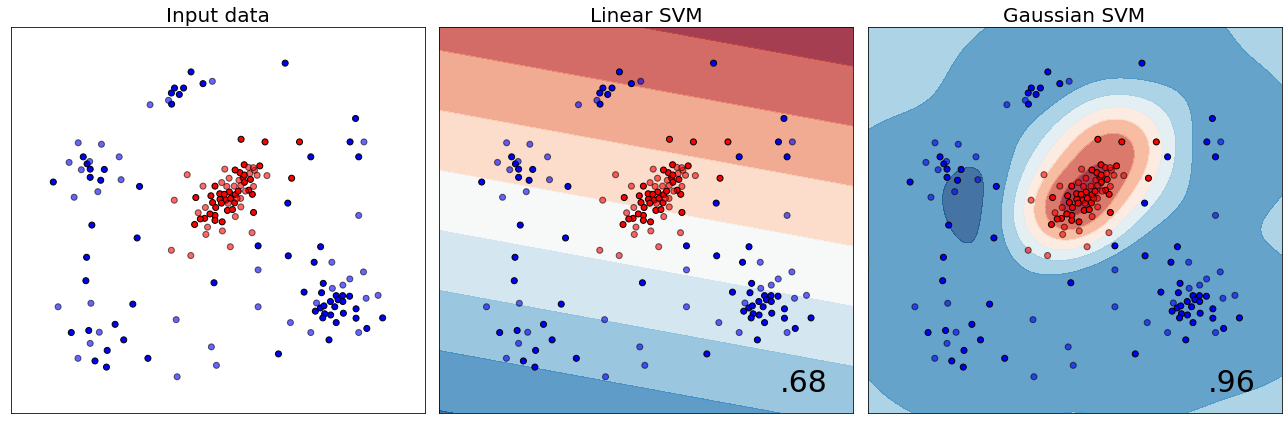

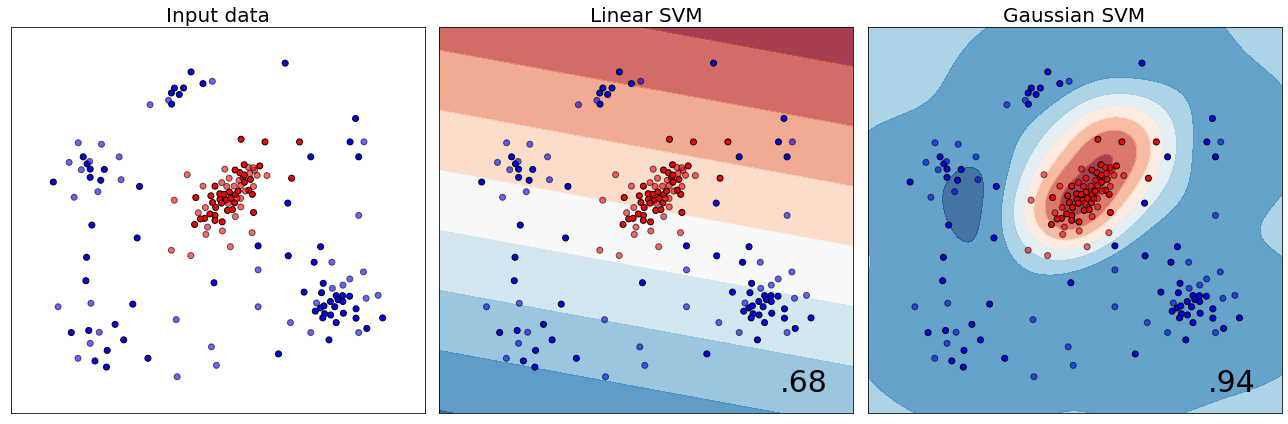

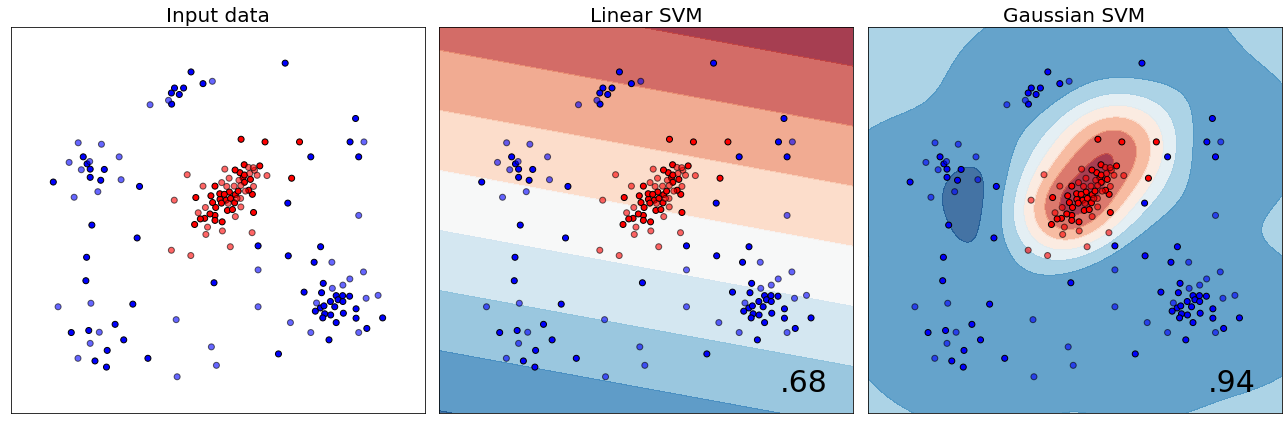

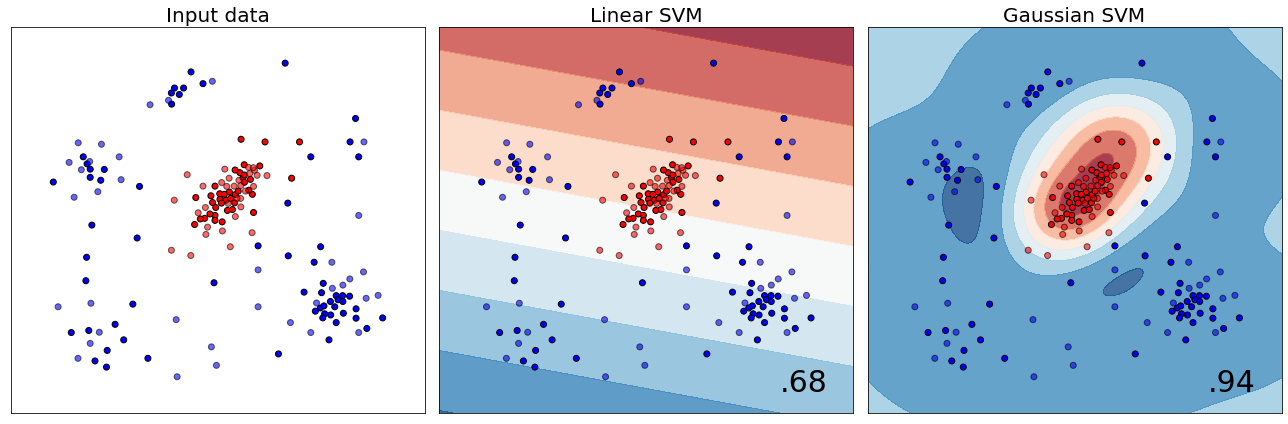

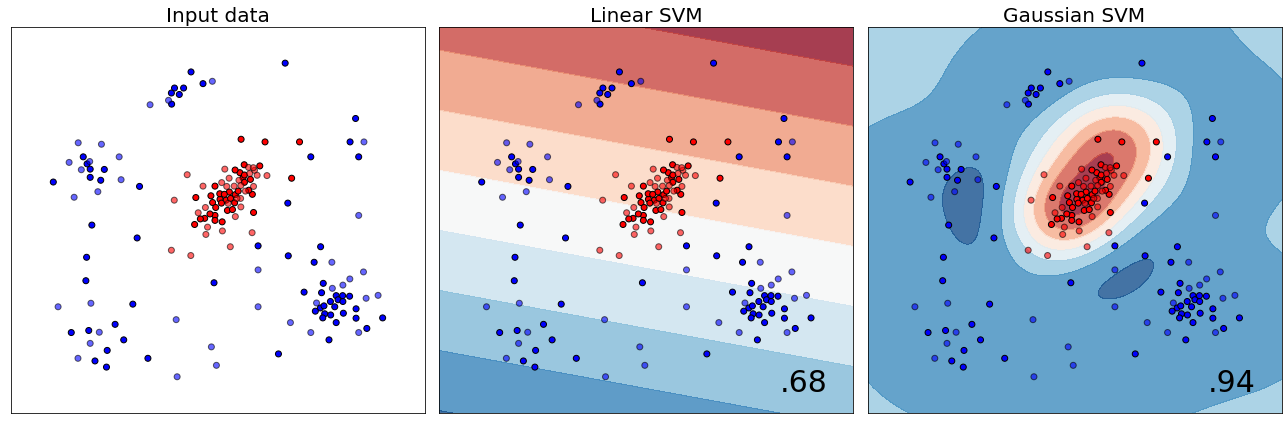

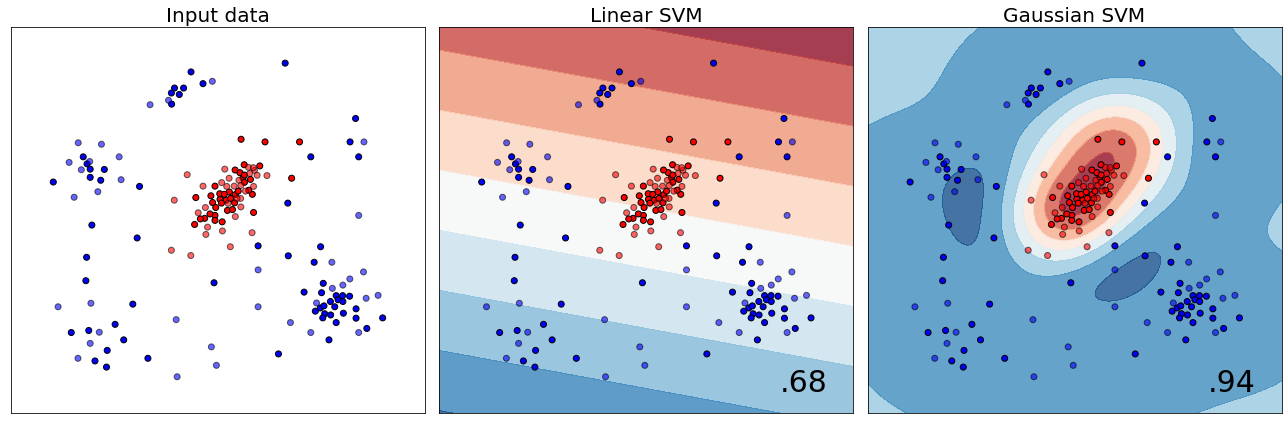

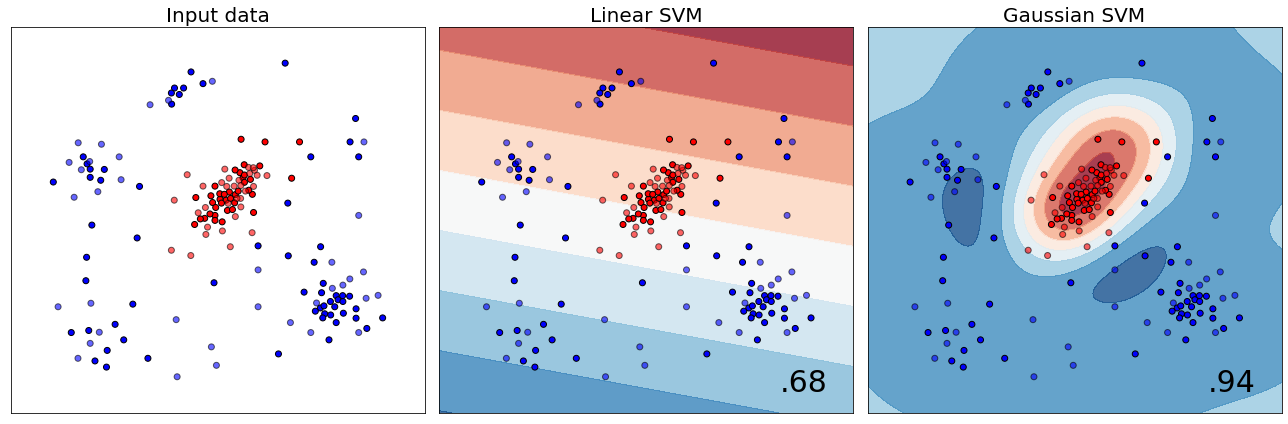

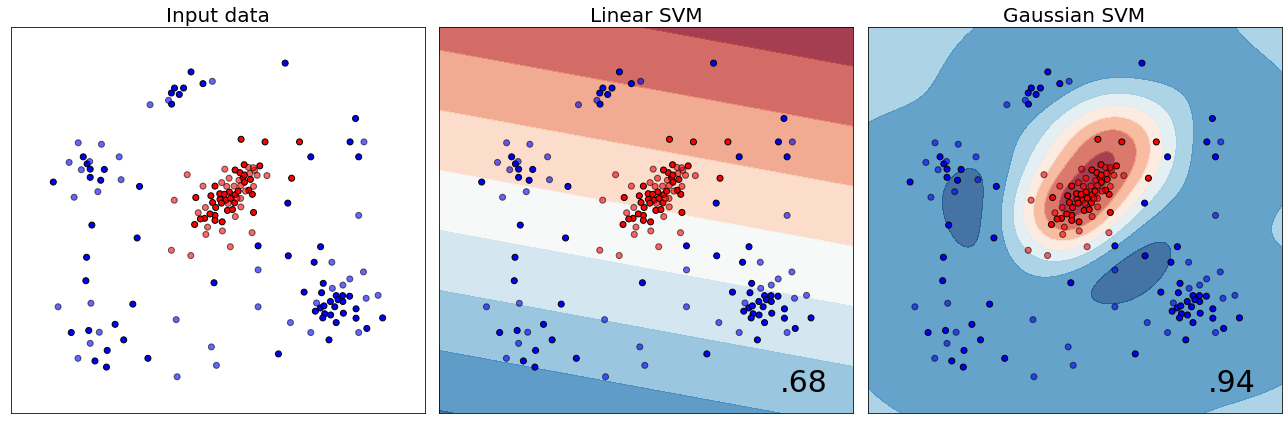

In [193]:
scores_c_check = []
for i in range(1,21):
    scores_c_check.append(run_classifiers(c_of_linear=i/20.0, c_of_rbf=i/20.0, gamma_of_rbf=2))

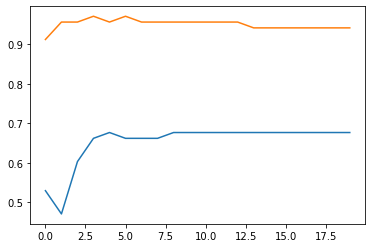

In [194]:
# Plotting the scores for differing C values on both kernels
plt.plot(scores_c_check)

Generally we can see that the C parameter doesn't affect the classification process too heavily for this dataset.

__What can you determine about the kernel methods from the graph above?__

__...but wait, isn't there an added parameter of the RBF kernel that we need to consider?__

### Back To The RBF Kernel

The RBF kernel provides an added sigma variable, which can be used to sharpen the kernel's classification:

![](sigma.png)

Sharpening the decision boundaries sounds great! Let's run a grid test now to look at how it improves our classification

In [ ]:
# This code might take a while to run...

scores_c_s_check = []
for i in range(1,21):
    for s in range(1,21):
        scores, f = run_classifiers(c_of_linear=i/20.0, c_of_rbf=i/20.0, gamma_of_rbf=s/20.0, show=False)
        scores_c_s_check.append([i, s, scores])
        f.clear()
        plt.close(f)
        #print(i, s)

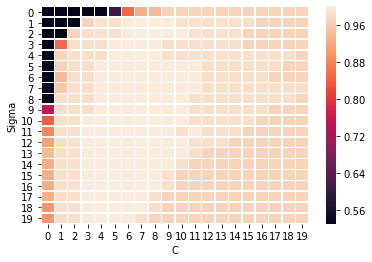

In [205]:
heatmap_data = []
for scs in scores_c_s_check:
    heatmap_data.append(scs[2][1])

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(np.array(heatmap_data).reshape(20, 20), linewidth=0.5)
ax.set(xlabel='C', ylabel="Sigma")
plt.show()

Hang on a second! We were expecting that the results involving a high sigma would be easily the best results. Why aren't we seeing a linear pattern here?

Let's take a closer look at what a classification involving a high sigma value looks like:

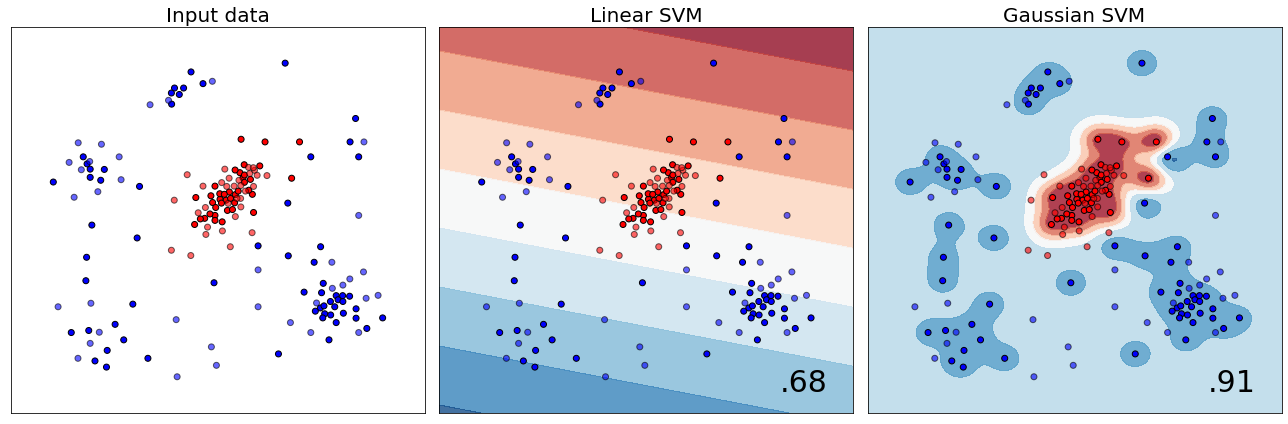

([0.6764705882352942, 0.9117647058823529], <Figure size 1296x432 with 3 Axes>)

In [209]:
run_classifiers(c_of_linear=20, c_of_rbf=20, gamma_of_rbf=20, show=True)

__Why doesn't the classifier like this sort of decision boundary?__